In [190]:
# Built-in imports
import warnings
from typing import List, Tuple, Dict

warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error
import statsmodels.api as sm

In [159]:
# Reading the dataset
df = pd.read_csv('../data/train.csv')
num = df.shape

# Preprocessing
df['GroupId'] = df.PassengerId.apply(lambda x: x.split('_')[0])
df['PassengerId'] = df.PassengerId.apply(lambda x: x.split('_')[1])
df.GroupId = df.GroupId.apply(lambda x: int(x))


# Breaking Cabin into deck, num and side
decks, nums, sides = [], [], []
lists = [decks, nums, sides]
for _, row in df.iterrows():
    if pd.isna(row.Cabin):
        for l in lists:
            l.append(np.nan)
    else:
        x = row.Cabin.split('/')
        for i, l in enumerate(lists):
            l.append(x[i])

df['Deck'] = decks
df['Num'] = nums
df['Side'] = sides

# Typecasting num values to int wherever possible, else keeping nan
df['Num'] = df.Num.apply(lambda x: int(x) if not pd.isna(x) else np.nan)

def get_last_name(name: str) -> str:
    if pd.isna(name): return ''
    else: return name.split(' ')[1]

df['LastName'] = df.Name.apply(lambda x: get_last_name(x))

df.head(3)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,GroupId,Deck,Num,Side,LastName
0,01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,1,B,0.0,P,Ofracculy
1,01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,2,F,0.0,S,Vines
2,01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,3,A,0.0,S,Susent


In [160]:
def get_encoder_dictionary(df: pd.DataFrame, encode_cols: List[str], **kwargs) -> Dict[str, LabelEncoder]:
    encoders: Dict[str, LabelEncoder] = {}
    
    # For every column we're fitting the encoder
    # with all non null values and save it in the
    # encoders dictionary with the key `column`
    for column in encode_cols:
        l = LabelEncoder(**kwargs)
        non_null_values: List[Any] = df[~pd.isna(df[column])][column].tolist()
        l.fit(non_null_values)
        encoders[column] = l
    
    return encoders

In [161]:
encoder_cols = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Transported', 'Deck', 'Side', 'LastName']

encoders = get_encoder_dictionary(df, encoder_cols)

In [191]:
def test_model(X, y, model, type_):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    if type_ == 'C':
        print(classification_report(y_test, preds))
        plt.figure(figsize=(7, 5))
        sns.heatmap(confusion_matrix(y_test, preds), annot=True, fmt='.0f')
        plt.show()
    else:
        report = '''
        MAE: {}
        MSE: {}
        RMSE: {}
        '''
        print(report.format(
            mean_absolute_error(y_test, preds),
            mean_squared_error(y_test, preds),
            np.sqrt(mean_squared_error(y_test, preds))
        ))
        sm.qqplot(y_test-preds, fit=True, line='45')
        plt.show()
    return

In [192]:
def impute_with_model(
    df: pd.DataFrame,
    target_attribute: str,
    exclude_cols: List[str],
    encoders: Dict[str, LabelEncoder],
    type_: str = 'C',
    test: bool = True,
) -> pd.DataFrame:
    
    df_copy = df.copy(deep=True)
    
    # Exit condition
    if df_copy[pd.isna(df_copy[target_attribute])].shape[0] == 0:
        return df_copy
    
    model = DecisionTreeClassifier() if type_.casefold().startswith('c') else LinearRegression()

    # Columns that're to be used for this model
    include_cols = [x for x in df_copy.columns if x not in exclude_cols]
    
    # Making a copy of the dataframe
    temp = df_copy[include_cols].copy(deep=True)
    temp.dropna(inplace=True)
    
    for c in temp.columns:
        if c in encoders:
            temp[c] = encoders[c].transform(temp[c])
    
    X, y = (temp[[x for x in df_copy.columns if x not in exclude_cols + [target_attribute]]], 
            temp[target_attribute])
    
    # NOT WORKING CURRENTLY
    if test: test_model(X, y, model, type_)

    # Final training
    model.fit(X, y)
    # Processing the dataframe for prediction
    X_new = df_copy[pd.isna(df_copy[target_attribute])]

    # Selecting only those rows
    X_new = X_new[X.columns]
    old_shape = X_new.shape[0]
    
    X_new.dropna(inplace=True)
    print('Had to drop {} rows'.format(old_shape - X_new.shape[0]))
    
    # Encoding values for prediction
    for column, encoder in encoders.items():
        if column in X_new.columns:
            X_new[column] = encoder.transform(X_new[column])

    print(temp.shape)
    
    predictions = model.predict(X_new)
    
    labels = encoders[target_attribute].inverse_transform(predictions) if (
        type_.casefold().startswith('c')
    ) else df[target_attribute].tolist()
    
    idx_preds_mapping: List[Tuple[int, str]] = list(zip(X_new.index.tolist(), labels))
    for idx, p in idx_preds_mapping:
        df_copy.loc[df_copy.index==idx, target_attribute] = p
    
    # For the rest of the missing attributes we're imputing with mode
    if type_.casefold().startswith('c'):
        df_copy.loc[pd.isna(df_copy[target_attribute]), 
                    target_attribute] = df_copy[target_attribute].mode().iloc[0]
    else:
        df_copy.loc[pd.isna(df_copy[target_attribute]), 
                    target_attribute] = df_copy[target_attribute].median()
    return df_copy



        MAE: 11.24454866840288
        MSE: 205.38612719003038
        RMSE: 14.331298866119232
        


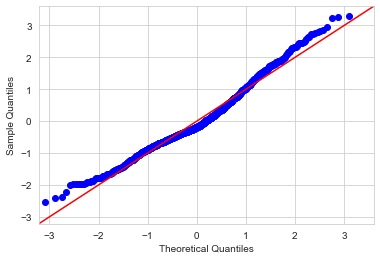

Had to drop 26 rows
(6764, 15)


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,GroupId,Deck,Num,Side,LastName
0,01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,1,B,0.0,P,Ofracculy
1,01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,2,F,0.0,S,Vines
2,01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,3,A,0.0,S,Susent
3,02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,3,A,0.0,S,Susent
4,01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,4,F,1.0,S,Santantines
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False,9276,A,98.0,P,Noxnuther
8689,01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False,9278,G,1499.0,S,Mondalley
8690,01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True,9279,G,1500.0,S,Connon
8691,01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False,9280,E,608.0,S,Hontichre


In [200]:
exclude_cols = ['PassengerId', 'Cabin', 'Name', 'Transported']
# target_attr = 'VIP'
target_attr = 'Age'

t = impute_with_model(df, target_attr, exclude_cols, encoders, type_='R', test=True)
# t = impute_with_model(df, 'HomePlanet', exclude_cols, encoders, type_='C', test=True)
t

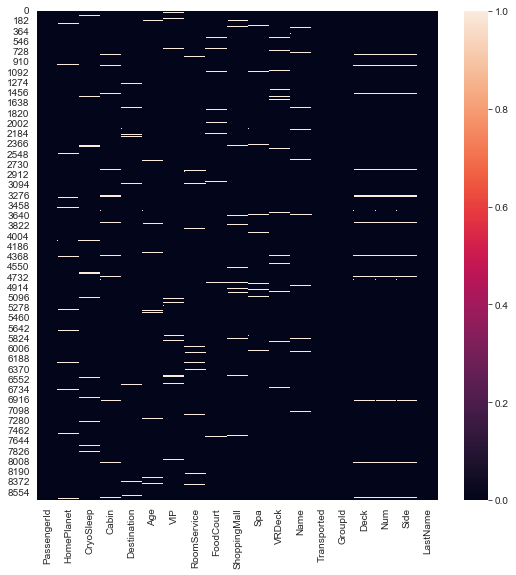

In [136]:
plt.figure(figsize=(9,9))
sns.heatmap(pd.isna(df))

In [137]:
# Columns that we'd have to impute

cols_to_imputes = [
    ('HomePlanet', 'C'),
    ('CryoSleep', 'C'),
    ('Destination', 'C'),
    ('Age', 'R'),
    ('VIP', 'C'),
    ('RoomService', 'R'),
    ('FoodCourt', 'R'),
    ('ShoppingMall', 'R'),
    ('Spa', 'R'),
    ('VRDeck', 'R'),
    # Cant predict Deck, Num or Side
    # ('Deck', 'C'),
    # ('Num', 'R'),
    # ('Side', 'C')
]

for col, type_ in cols_to_imputes:
    print(col)
    df = impute_with_model(df, col, exclude_cols, encoders, type_,)

HomePlanet
Had to drop 33 rows
(6764, 15)
CryoSleep
Had to drop 39 rows
(6932, 15)
Destination
Had to drop 28 rows
(7110, 15)
Age
Had to drop 22 rows
(7264, 15)
VIP
Had to drop 21 rows
(7421, 15)
RoomService
Had to drop 15 rows
(7603, 15)
FoodCourt
Had to drop 18 rows
(7769, 15)
ShoppingMall
Had to drop 10 rows
(7934, 15)
Spa
Had to drop 5 rows
(8132, 15)
VRDeck
Had to drop 4 rows
(8310, 15)


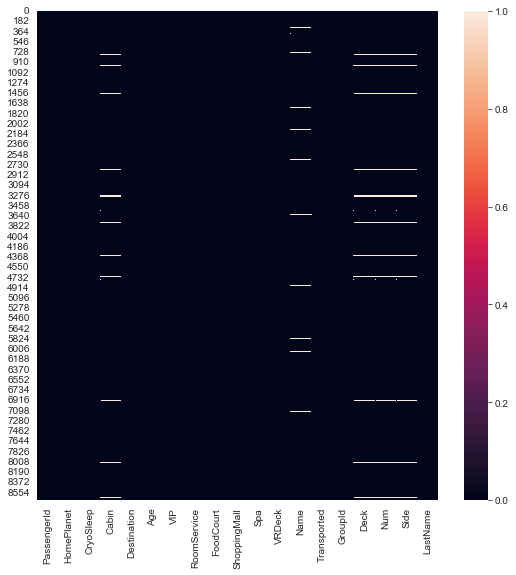

In [138]:
plt.figure(figsize=(9,9))
sns.heatmap(pd.isna(df))

In [139]:
!start .